# Diffusion Model: Task 2

This notebook includes work performed on task 2 of the project to model diffusion from the inner stream into the bubble.

In task 1, I developed a fully numerical model to calculate the system modeled by the Epstein-Plesset model and demonstrated reasonable agreement. Now, I will relax the first of the two assumptions of the Epstein-Plesset model,

**1. a constant diffusivity of carbon dioxide in polyol with respect to carbon dioxide concentration**
2. a constant carbon dioxide concentration in an infinite bulk. 

Here, we develop a model that incorporates the effect of concentration on the diffusivity. This means that the diffusivity will vary over both time and space. We use measurements using gravimmetry-axisymmetric drop-shape analysis (G-ADSA) performed in the Di Maio lab during the summer of 2019 for the diffusivity as a function of concentration $D(c)$.

**Goals**: 

1. Demonstrate agreement of concentration-dependent model developed with the concentration-independent model from task 1 when the model for concentration dependence of diffusivity is constant.
2. Estimate the uncertainty in the diffusivity as a function of concentration of carbon dioxide due to experimental uncertainty 
3. Speed up computation time

## Setup

### Import Libraries

In [2]:
# adds custom libraries to path
import sys
sys.path.append('../libs/')

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# imports custom libraries
import polyco2
import diffn
import flow
import bubble
import bubbleflow
import analytics as an
import finitediff as fd

# plotting
import plot.diffn as pltd
import plot.bubble as pltb
import plot.genl as pltg

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload

### Declare Model Parameters

In [3]:
# flow parameters for experiments in 20200905_80bar folder
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken in videos of effect of flow rate on 20200905_80bar [m]
d = 0.096

# bubble growth model parameters
dt = 1E-12 # [s]
R_nuc = 5E-6 # [m] arbitrary bubble size for comparing models

# grid parameters
R_max = 100E-6 # outer radius [m]

# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = '1k3f_22c.csv'

# equation of state data
eos_co2_file = 'eos_co2_22-0C.csv'

# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

### Calculate Flow Parameters

In [4]:
# computes inner stream radius [m] and velocity [m/s]
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
# inlet pressure [Pa]
p_in = P_ATM - dp
# nucleation time [s]
t_nuc = d/v

### Compute Epstein-Plesset Result as a Benchmark

In [5]:
# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# Epstein-Plesset solution for comparison
t_eps, m, D, p, p_bub, if_tension, c_s, c_bulk, R_eps, rho_co2 = bubble.grow(t_nuc, *eps_params)
props_list_eps = (R_eps, m, p, p_bub, rho_co2, if_tension)

# uses 2nd-order Taylor stencil to compute concentration gradient at the surface of the bubble
dcdr_eps = bubble.calc_dcdr_eps(c_bulk, c_s, R_eps, D, np.asarray(t_eps) - t_nuc)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:231: RuntimeWarning: divide by zero encountered in true_divide
  1/np.sqrt(np.pi*D*(np.asarray(t))))


## Analysis

In [6]:
N = 100
dt = 1E-12 # [s]
dr = R_max/N # [m]
D_max = 3E-9
dt_max = 0.5*(dr**2/D_max) # keeps time step below half of diffusion time scale

t_flow1, c1, t_num1, m1, D, p1, p_bub1, if_tension1, \
c_bub, c_bulk, R1, rho_co21, v, dr_list = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max)

In [8]:
t_flow2, c2, t_num2, m2, D, p2, p_bub2, if_tension2, \
c_bub, c_bulk, R2, rho_co22, v, dr_list = bubbleflow.num_vary_D(t_nuc, eps_params, R_max, N, dc_c_s_frac, D_fn=diffn.fixed_D)

### Plot Results

../libs\plot\bubble.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


(0.0, 1e-06)

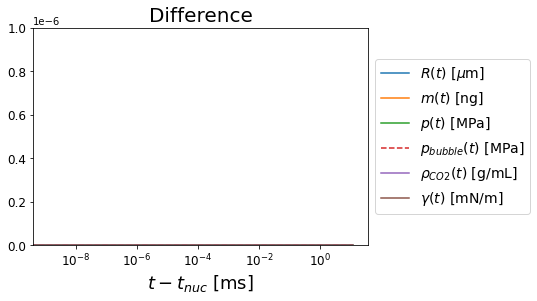

In [11]:
props_list_diff = [np.abs(np.asarray(props_list2[i]) - np.asarray(props_list1[i])) for i in range(len(props_list1))]
ax = pltb.all_props(t_num1, t_nuc, props_list_diff, x_log=True, title='Difference')
ax.set_yscale('linear')
ax.set_ylim([0, 1E-6])

We see no difference between the two models. Thus, we can use `num_vary_D()` to perform computations with a fixed diffusivity by passing in a function for diffusivity that is constant.

### Evaluating Models of Concentration Dependence

Having checked that my new function works, I now want to evaluate the effect of using different models for the concentration dependence.

The first comparison I want to make is between the predictions using the pressurization vs. the depressurization data for $D(c)$. As seen in the plot below, the estimates of the diffusivity during depressurization were higher, likely because (1) the concentration starts high and goes low during depressurization, and the diffusivity does the same, so the average diffusivity is slightly higher than the final value, whereas the opposite is true during pressurization and (2) the depressurization was performed over greater pressure steps, so the diffusion was farther from Fickian (though not dramatically so).

<div>
    <img src="figures/1k3f_30c_D_sqrt.png" alt="Drawing" style="width: 400px;"/>
</div>

The second comparison I want to make is between different models of $D(c)$. I am so far considering a power law and a linear model. I may just compare power law fits to the pressurization and depressurization data.

The models used from fitting the data are saved in `g-adsa_results/D_c_power_law.csv`. The computations to achieve the fit are documented in `20201124_1k3f_D_vs_rho_co2.ipynb`.

In [48]:
# fixed inputs
N = 3200
half_grid = True
dt_max = 0.5*(R_max/N)**2/D_max


# varied inputs
D_fn_ = [diffn.D_p, diffn.D_dp]

# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(D_fn_)
# groups inputs for each function
num_input_list = [(t_nuc, eps_params, R_max, N, dc_c_s_frac, dt_max, D_fn_[i], half_grid) for i in range(len(D_fn_))]

In [49]:
R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_vary_D at 0x000001270B4EC8C8>
halving grid
halving grid
1252574967.2790403
3.1249999999999997e-07
391.5354203877062
halving grid
halving grid
627428021.6840571
6.249999999999999e-07
392.2487631898141
halving grid
halving grid
316225350.5054664
1.2499999999999999e-06
395.33780344549814
Computing <function num_vary_D at 0x000001270B4EC8C8>
halving grid
halving grid
1252225970.8750818
3.1249999999999997e-07
391.47530949500145
halving grid
halving grid
627040635.1419424
6.249999999999999e-07
391.99953900195743
halving grid
halving grid
315392162.6993656
1.2499999999999999e-06
394.25169021280556


#### Plot Results

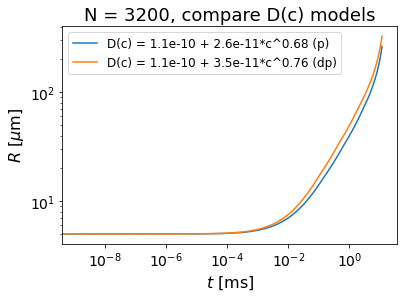

In [52]:
filepath_D_c='../g-adsa_results/D_c_power_law.csv'
df_D = pd.read_csv(filepath_D_c)
D0, A_p, k_p = df_D['p']
D0, A_dp, k_dp = df_D['dp']

label_list = ['D(c) = {0:.2g} + {1:.2g}*c^{2:.2f} (p)'.format(D0, A_p, k_p),
              'D(c) = {0:.2g} + {1:.2g}*c^{2:.2f} (dp)'.format(D0, A_dp, k_dp)]

fig = plt.figure()
ax = fig.add_subplot(111)

for raw_vals, label in zip(raw_vals_list, label_list):
    _, _, t, R = raw_vals
    ax.plot(s_2_ms*(np.asarray(t) - t[0]), m_2_um*np.asarray(R), label=label)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$t$ [ms]', fontsize=ax_fs)
ax.set_ylabel(r'$R$ [$\mu$m]', fontsize=ax_fs)
ax.set_title('N = 3200, compare D(c) models', fontsize=t_fs)
ax.tick_params('both', labelsize=tk_fs)
ax.legend(fontsize=l_fs)

The difference is not negligible, but it might be small enough that downstream results are not affected qualitatively. I will plot the fractional difference between the predictions below.

0.20955840136367584


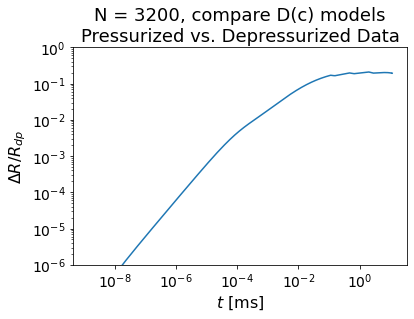

In [54]:
raw_vals_p, raw_vals_dp = raw_vals_list

_, _, t_p, R_p = raw_vals_p
_, _, t_dp, R_dp = raw_vals_dp

R_p_interp = np.interp(t_dp, t_p, R_p)
R_dp = np.asarray(R_dp)

R_frac_diff = np.abs(R_p_interp - R_dp) / R_dp

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(s_2_ms*(np.asarray(t_dp) - t_dp[0]), R_frac_diff)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$t$ [ms]', fontsize=ax_fs)
ax.set_ylabel(r'$\Delta R / R_{dp}$', fontsize=ax_fs)
ax.set_title('N = 3200, compare D(c) models\nPressurized vs. Depressurized Data', fontsize=t_fs)
ax.tick_params('both', labelsize=tk_fs)
ax.set_ylim([1E-6, 1])

print(np.max(R_frac_diff))

The difference peaks around 20% about 0.1 ms after bubble nucleation. The discrepancy is certainly not negligible, but might not be so large that it affects our conclusions in later analysis.

## Compare Effect of D(c) Models Using Logarithmic, Adaptively Meshed Grid

In [7]:
reload(bubbleflow)
reload(diffn)
reload(an)

# varied inputs
D_fn_ = [diffn.D_p, diffn.D_dp]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(D_fn_)

# fixed parameters
N = 28
k = 1.6
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_once_manual
remesh_freq = 100 # heuristic
interp_kind = 'quadratic'
i_remesh = 3
dk = 0.1
adapt_freq = 5


# computes smallest length scale in grid [m]
r_arr = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr[1] - r_arr[0]
# defines smallest time step to remain below smallest diffusion time scale
D_max = max(diffn.D_p(500), diffn.D_dp(500))
dt_max = 0.5*d**2/D_max


# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
                  'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'k' : k},
                  'adapt_freq' : adapt_freq, 'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq,
                  'remesh_params' : {'interp_kind' : interp_kind, 'i_remesh' : i_remesh, 'dk' : dk}} 
                  for D_fn in D_fn_]

In [ ]:
R_diff_list, _, raw_vals_list, _ = an.compare_R(num_input_list, num_fn_list, None, None, ret_comp_time=True)

In [ ]:
t_ref = raw_vals_list[0][0]

ax = pltd.diff(t_ref, R_diff_list, None, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of Diffusivity Function on Error')